In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import sympy as sym
from numpy.random import random
from copy import deepcopy
from matplotlib.animation import FuncAnimation
from time import time
from numba import jit
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap



# Animating species evolution in a metacommunity

## Building a time evolveable phylogeny

In [2]:
# Construindo uma filogenia evoluível no tempo.

class Phylogeny():
    
    dt = 1
    
    def __init__(self, F, species, species_marker, extinctions=[], t=0):
        self.F = F
        self.species_marker = species_marker
        self.species = species
        self.N = self.F.shape[0]
        self.t = t
        self.extincts = extinctions # Markers of species!
        
    def speciation(self, speciations=[], newspecies=[]):
        
        marker = self.N - 1
        i = 0
        new = len(newspecies)
        for e in speciations:
            
            # Update species list.
            # Add new marker in order of the matrix rows/columns.
            j = self.species_marker.index(e)
            marker += 1
            self.species_marker.insert(j+1, marker)
            #print(self.species_marker[j], marker)
            
            # Add species names in order of the markers.
            if (i<new):
                self.species.append(newspecies[i])
                i+=1
            else:
                self.species.append(("sp %d" % (marker+1)))
            
            # Insert new species in matrix.
            self.F = np.insert(self.F, j+1, self.F[:,j], axis=1)
            self.F = np.insert(self.F, j+1, self.F[j,:], axis=0)
            
        
        self.N = self.F.shape[0]
        
    def extinction(self, extinctions=[]):
        
        # Add new extinctions (markers) to the list.
        self.extincts.extend(extinctions)
        
        # Make and return a list in order of the matrix with the markers of the extinct species.
        extinctions_list = []
        for e in self.extincts:
            extinctions_list.append(self.species_marker.index(e))
            #print(self.species_marker.index(e))
        
        return extinctions_list
        
    def update(self, extinctions=[], speciations=[]):
        # extinctions and speciations are list of the markers!
    
        # Add colums and rows to matrix to incorporate new species.
        self.speciation(speciations)

        # Add new extinct species to list and get a list of matrix indexes of extinct species.
        extinctions_list = self.extinction(extinctions)
                    
        # Construct the update matrix.
        Nidentity = np.identity(self.N)
        dF = np.ones((self.N,self.N)) - Nidentity
        for i in extinctions_list:
            dF[i,i] = 1
        
        self.F = self.F + dF*self.dt
        self.t += self.dt
        
    # Faz a dinâmica da filogenia.
    def evolve(self, speciation_prob, extinction_prob):
        speciations = []
        extinctions = []
        # itera sobre as espécies (nos índices da matriz)
        for j in range(self.N):
            # Verifica se i está extinta.
            if(not(self.species_marker[j] in self.extincts)):
                if(random()<extinction_prob): # Extinção
                    extinctions.append(self.species_marker[j])
                elif(random()<speciation_prob): # Especiação
                    speciations.append(self.species_marker[j])
                

        # Atualiza a filogenia.
        self.update(speciations=speciations, extinctions=extinctions)
        print("Alterations: %.1f" % self.t, speciations, extinctions)

            

## Defining the Segment class, used to plot a phylogeny.

In [3]:
class Segment():
    def __init__(self, species_set, xf, anterior_segment='none', posterior_segment1='none', posterior_segment2='none'):
        self.lspecies = set(species_set)
        self.xf = xf
        self.neighborhood = [anterior_segment, posterior_segment1, posterior_segment2]
    #def add(species_set, xf, anterior_segment='none', posterior_segment1='none', posterior_segment2='none'):
        

def segmentation(phylogeny):
    
    E = phylogeny.t - phylogeny.F
    
    # Define the iterative function of segmentation.
    def segmenta(i, anterior_segment, setm, xf):
        
        # Set of the species that share the node divergence.
        set1 = set(np.where(np.abs(E[i] - xf)<phylogeny.dt/2)[0])
        ia=i
        # Least element index in the set - used as reference to the segmentation.
        #i = min(conj1)
        # In line of i, the least element biggest that xm (anterior minimal element).
        # This element is the final x of these segment and the init of the next segments.
        #L = E[i,E[i]>xm]
        # 
        #bad_indexes = set()
        # If it is not biggest that xm then it's equal to xm.
        #while(len(L)==0):
        #    bad_indexes.add(i)
        #    i = min(conj1 - bad_indexes)
        #    L = E[i,E[i]>xm]
        #xm1 = L.min()
        xf1 = -1
        for i in set1:
            L = E[i,E[i]>xf]
            if((len(L)!=0)): 
                xf1 = L.min()
                #print(ia, " ", i, " ", xf)
                break
        if(xf1<0):
            xf1 = xf
            print("\nErrooooooooooooooo\n")
            print(E)
            print(ia, " ", i, " ", xf)
            #return -1
        #else:
        #    display(sym.Matrix(E))
        #    print(ia, " ", i, " ", xm)
            #xm1 = xm
        # Add the new segment (diverging segment).
        segment.append(Segment(set1, xf1, anterior_segment))
        # Position of the segment 1 (diverging).
        anterior_segment1 = len(segment) - 1
        # If there are more species in this set continue the segmentation.
        #if(np.abs(xm1 - phylogeny.t)<phylogeny.dt/2):
        if(len(set1)>1):
            if(xf1>=phylogeny.t):
                print(E,"\n")
                print(ia, i, xf1)
            else:
                segmenta(i, anterior_segment1, set1, xf1)

        # Set of the species that share the same segment (complement).
        set2 = setm - set1
        #print(set1, set2)
        # Least element index in the set - used as reference to the segmentation.
        #i = min(conj2)
        # In line of i, the least element biggest that xm (anterior minimal element).
        # This element is the final x of these segment and the init of the next segments.
        # If it is not biggest that xm then it's equal to xm.
        xf2 = -1
        for i in set2:
            L = E[i,E[i]>xf]
            if((len(L)!=0)): 
                xf2 = L.min()
                #print(ia, " ", i, " ", xf)
                break
        if(xf2<0):
            xf2 = xf
            print("\nErrooooooooooooooo\n")
            print(E)
            print(ia, " ", i, " ", xf)
            #return -1
        
        # Add the new segment (converging segment).
        segment.append(Segment(set2, xf2, anterior_segment))
        # Position of segment 2 (converging).
        anterior_segment2 = len(segment) - 1
        # If there are more species in this set continue the segmentation.
        #if(np.abs(xm2 - phylogeny.t)<phylogeny.dt/2):
        if(len(set2)>1):
            if(xf2>=phylogeny.t):
                print(E,"\n")
                print(ia, i, xf2)
            else:
                segmenta(i, anterior_segment2, set2, xf2)
            
        # Add the indexes of the posterior segments to the neighborhoods of anterior segment.
        #posterior_segments = (anterior_segment1, anterior_segment2)
        segment[anterior_segment].neighborhood[1] = anterior_segment1
        segment[anterior_segment].neighborhood[2] = anterior_segment2

    # Species number (rows number).
    N = E.shape[0]
    # Minimal element of line 0 -- start point to segmentation.
    xf = E[0].min()
    # Species set emerging from the first node.
    setm = set([i for i in range(N)])
    # Init the segmentation - first segment.
    segment = []
    segment.append(Segment(setm, xf))
    
    if(N>1):
        segmenta(0, 0, setm, xf)
        
    print("Segmentation with %d / %d segments\n" % (len(segment), (2*N-1)))
    
    return segment

## Ilustring a phylogeny

In [48]:
# Ilustring a phylogeny.
def phyloplot(
        ax,
        phylogeny,
        colormap='rainbow',
        text_color='gray',
        species_color='gray',
        species_size=200,
        order=2,
        xscale=1,
        yscale=1,
        NspeciesMax=0):
    
    # Redefine NspeciesMax if is not defined by user.
    if(NspeciesMax==0):
        NspeciesMax=phylogeny.N
        
    # Building the new colormap
    #print(NspeciesMax)
    cmap = plt.get_cmap(colormap)
    #Ncolors = cmap.N
    mapColors = cmap(np.linspace(0, 1, NspeciesMax))
    #print(mapColors)
    new_index = 0
    reMapColors = deepcopy(mapColors)
    #print(phylogeny.species_marker)
    for e in phylogeny.species_marker:
        reMapColors[new_index] = mapColors[e]
        new_index += 1
    # New colormap.
    #print(reMapColors)
    colormap = ListedColormap(reMapColors)
    #print(colormap)
    levels = np.linspace(-0.5, NspeciesMax-0.5, NspeciesMax+1)
    norm = BoundaryNorm(levels, ncolors=NspeciesMax, clip=True)
    
    rate = yscale/xscale**2
    
    #=1.05*phylogeny.t#=1.05*phylogeny.N
    # Iterative function that builds the bifurcations.
    def bifurca(xi, yi, indexes):
        # This function plot a bifurcation.
        if(order=='exp'):
            def bifurcaplot(xi, yi, xf1, yf1, xf2, yf2):
                # Parte superior da bifurcação.
                a1 = (xf1 - xi)/np.exp(np.abs(yf1 - yi))
                yorder = np.arange(np.exp(min(yi, yf1)), np.exp(max(yi, yf1)), 0.1/a1) # Para fazer os pontos ficarem distribuídos linearmente no plot.
                y1 = np.log(yorder) # Para fazer os pontos ficarem distribuídos linearmente no plot.
                #y1 = np.arange(min(yi, yf1), max(yi, yf1), 0.01)
                x1 = xi + a1*np.exp(np.abs(y1-yi))
                #y1c = phylogeny.N - y1
                #ax.scatter(x1, y1, c=y1c, s=10, cmap=colormap, norm=norm)
                ax.plot(x1, y1, c=species_color, lw=4, zorder=1)
                # Parte inferior da bifurcação.
                a2 = (xf2 - xi)/np.exp(np.abs(yf2 - yi))
                yorder = np.arange(np.exp(min(yi, yf2)), np.exp(max(yi, yf2)), 0.1/a2) # Para fazer os pontos ficarem distribuídos linearmente no plot.
                y2 = np.log(yorder) # Para fazer os pontos ficarem distribuídos linearmente no plot.
                #y = np.arange(min(yi, yf2), max(yi, yf2), 0.1)
                x2 = xi + a2*np.exp(np.abs(y2 - yi))
                #y2c = phylogeny.N - y2
                #ax.scatter(x2, y2, c=y2c, s=10, cmap=colormap, norm=norm)
                ax.plot(x2, y2, c=species_color, lw=4, zorder=1)
        elif((order>=1)and(order<=4)):
            def bifurcaplot(xi, yi, xf1, yf1, xf2, yf2):
                # Parte superior da bifurcação.
                a1 = (xf1 - xi)/np.power(np.abs(yf1 - yi), order)
                yorder = np.linspace(np.power(min(yi, yf1),order), np.power(max(yi, yf1),order), int(100*(rate/a1))) # Para fazer os pontos ficarem distribuídos linearmente no plot.
                y1 = np.power(yorder, 1./order) # Para fazer os pontos ficarem distribuídos linearmente no plot.
                #y1 = np.arange(min(yi, yf1), max(yi, yf1), 0.01)
                x1 = xi + a1*np.power(np.abs(y1-yi),order)
                #y1c = phylogeny.N - y1
                #ax.scatter(x1, y1, c=y1c, s=10, cmap=colormap, norm=norm)
                ax.plot(x1, y1, c=species_color, lw=4, zorder=1)
                # Parte inferior da bifurcação.
                a2 = (xf2 - xi)/np.power(np.abs(yf2 - yi),order)
                yorder = np.linspace(np.power(min(yi, yf2),order), np.power(max(yi, yf2),order), int(100*(rate/a2))) # Para fazer os pontos ficarem distribuídos linearmente no plot.
                y2 = np.power(yorder, 1./order) # Para fazer os pontos ficarem distribuídos linearmente no plot.
                #y = np.linspace(min(yi, yf2), max(yi, yf2), 100)
                x2 = xi + a2*np.power(np.abs(y2 - yi),order)
                #y2c = phylogeny.N - y2
                #ax.scatter(x2, y2, c=y2c, s=10, cmap=colormap, norm=norm)
                ax.plot(x2, y2, c=species_color, lw=4, zorder=1)
        else:
            print("\nError: this order cannot be computed.\n")
            return -1

        i1, i2 = indexes
        
        # Upper branch.
        xf1 = segment[i1].xf
        #yf1 = phylogeny.N - (sum(segment[i1].lspecies)/len(segment[i1].lspecies))
        yf1 = phylogeny.N - (min(segment[i1].lspecies) + max(segment[i1].lspecies))/2
                       
        # Lower branch.
        xf2 = segment[i2].xf
        #yf2 = phylogeny.N - (sum(segment[i2].lspecies)/len(segment[i2].lspecies))
        yf2 = phylogeny.N - (min(segment[i2].lspecies) + max(segment[i2].lspecies))/2
        
        # Plot the bifurcation.
        bifurcaplot(xi, yi, xf1, yf1, xf2, yf2)

        if(segment[i1].neighborhood[1]!='none'):
            bifurca(xf1, yf1, segment[i1].neighborhood[1:])
        
        if(segment[i2].neighborhood[1]!='none'):
            bifurca(xf2, yf2, segment[i2].neighborhood[1:])
            
        
    ax.axis([0, 1.05*xscale, (phylogeny.N + 1) - yscale, yscale])#0
    ax.set_yticks([])
    
    Nticks_scale = int(10*phylogeny.t/xscale)
    Nticks = min(max(Nticks_scale, 1), 9)
    time_axis = np.linspace(0, phylogeny.t, Nticks)
    reverse_time = [("%.1f" % (phylogeny.t - timei)) for timei in time_axis]
    direct_time = [("%.1f" % (timei)) for timei in time_axis]
    ax.set_xticks(time_axis)
    ax.set_xticklabels(direct_time, fontsize=20, color=text_color)
    ax.text(0.05*xscale, 0.95*yscale, (r"Tempo: %.1f milhões de anos" % phylogeny.t), color=text_color, fontweight="bold", fontsize=24, va="center", ha="left")
    #ax.set_xlabel(r"milhares de gerações passadas", color=text_color, fontweight="bold", fontsize=14, va="top")

    E = phylogeny.t - phylogeny.F
    
    segment = segmentation(phylogeny)
    
    # Plotando início
    i = 0
    xf = segment[i].xf
    #yf = phylogeny.N - (sum(segment[i][1])/len(segment[i][1]))
    yf = phylogeny.N - (min(segment[i].lspecies) + max(segment[i].lspecies))/2
    x = np.linspace(0, xf, int(200//xscale))
    y = yf*np.ones(len(x))
    #yc = phylogeny.N - y
    #ax.scatter(x, y, c=yc, s=10, cmap=colormap, norm=norm)
    ax.plot(x, y, c=species_color, lw=4, zorder=1)
    
    if(len(segment)>1):
        # Iniciando a cadeia de bifurcações.
        bifurca(xf, yf, segment[i].neighborhood[1:])
    
    # Plotando espécies finais.
    dy = 0.000001
    x = np.diag(E)
    y = phylogeny.N - np.arange(0, phylogeny.N)
    yc = phylogeny.N - y
    ax.scatter(x, y, c=yc, s=species_size, cmap=colormap, edgecolors=species_color, norm=norm, zorder=2)
    #ax.axis("equal")
    for i in range(phylogeny.N):
        ax.text(x[i]+xscale/25, y[i], (phylogeny.species[phylogeny.species_marker[i]]), color=text_color, fontweight="bold", fontsize=16, va="center", ha="left")
        #radius = (2*yscale - phylogeny.N - 1)/20
        #circle = plt.Circle((x[i]+xscale/100, y[i]), radius=radius, facecolor=colormap(yc[i]/NspeciesMax), edgecolor=species_color)
        #ax.add_patch(circle)



## Building a Metacommunity with phylogeny incorporated.

In [28]:
# Funções de probabilidade

class Metacommunity():
    
    def __init__(self, S, H, phylo, ispecies=[0], jspecies=[0]):
        
        self.Nsitesperline = len(S[0])
        self.Nsites = Nsitesperline**2
        
        self.I = np.zeros((Nsitesperline,Nsitesperline)) # Isolation matrix.
        self.Nspecies = phylo.N

        # Renew S definition.
        self.S = S + H - 1 # This definition has problems.
        
        # Phylogeny.
        self.phylo = phylo
        
        # ispecies, jspecies. Site indexes where the species emerged.
        self.ispecies = ispecies
        self.jspecies = jspecies
        
        # Histogram of species.
        self.species_hist = self.species_histogram()
        
        # Pre-define dynamic parameters.
        self.dynamic_parameters()
        
    
    def dynamic_parameters(self, pi=0.8, mu=0.1, nu=0.1):
        
        self.pi = pi # Colonization probability.
        self.mu = mu # Dead probability - mortality.
        self.nu = nu # Speciation intrinsec probability.
    
    
    def species_update(self, species_marker):
        self.Nspecies += 1
        return self.Nspecies
    
    
    def list_extinctions(self):
        
        all_extinctions = []
        for i in range(self.phylo.N):
            if(self.species_hist[i]==0):
                all_extinctions.append(i)
            
        new_extinctions = []
        for spi in all_extinctions:
            spi_is_listed = False
            for spj in self.phylo.extincts:
                #print("Extincts markers: ", spi, " ", spj)
                if(spi==spj):
                    spi_is_listed = True
                    break
            if(not spi_is_listed):
                new_extinctions.append(spi) # Note the compatibility with phylo notation.
        
        return new_extinctions
    
    
    def species_histogram(self):
        hist, bins_edges = np.histogram(self.S, bins=self.Nspecies, range=(0.5,self.Nspecies+0.5))#bins=[i for i in range(1, self.Nspecies)]
        return hist
    
    
    def matrix_dynamic(self, isolationEffect=False, environmentalEffect=False, enableInvasion=False):

        # Make a copy of S matrix.
        Snew = deepcopy(self.S)
        
        # List of new speciations [(marker_origin, new_marker, (i,j))].
        speciation_list = []
        
        def Lorentzian(d, a=Nsitesperline):
            L = a/(a + d**2)
            return L

        # Dynamic for a site.
        def site_isolation(i,j):
            
            # Number of neighbors of same specie.
            v = 0
            
            # First neighbor.
            if(j<self.Nsitesperline-1):
                if(self.S[i,j]==self.S[i,j+1]):
                    v+=1
            # Second neighbor.
            if(i>0):
                if(self.S[i,j]==self.S[i-1,j]):
                    v+=1
            # Third neighbor.
            if(j>0):
                if(self.S[i,j]==self.S[i,j-1]):
                    v+=1
            # Fourth neighbor.
            if(i<self.Nsitesperline-1):
                if(self.S[i,j]==self.S[i+1,j]):
                    v+=1
            
            # Isolation index
            self.I[i,j] = 0.5*self.I[i,j] + 0.5*(1/(v*v + 1))
            
            
        def site_speciation(i, j):
            
            if(environmentalEffect):
                # Indexes of precipitation and thermal adaptability.
                Pij = np.exp(-4*(np.abs(self.jspecies[int(self.S[i,j]-1)] - j)/Nsitesperline))
                Tij = np.exp(-4*(np.abs(self.ispecies[int(self.S[i,j]-1)] - i)/Nsitesperline))
                # Compute index of natural selection pressure.
                naturalSelectionIndex = (1 - Pij)*(1 - Tij)
            else:
                naturalSelectionIndex = 1
            
            if(isolationEffect):
                geneticDriftIndex = self.I[i,j]
            else:
                geneticDriftIndex = 1
                
            if((self.species_hist[int(self.S[i,j]-1)]>1) and (random()<self.nu*geneticDriftIndex*naturalSelectionIndex)):
                # Gambiarra anti politomia.
                is_politomy=False
                for e in speciation_list:
                    if(e[0]==self.S[i,j]):
                        is_politomy=True
                        break
                if(not is_politomy):
                    markerNewSpecies = self.species_update(self.S[i,j])
                    #print(markerNewSpecies)
                    #Snew[i,j] = markerNewSpecies
            
                    return markerNewSpecies
             
            return 0
                            
            
        def colonizer(i, j):
            vizinho = (4*random())//1
            # Propaga para vizinho 2.
            if(vizinho == 0):
                return (i-1), j
            # Propaga para vizinho 1.
            if(vizinho == 1):
                return i, (j+1)
            # Propaga para vizinho 4.
            if(vizinho == 2):
                return (i+1), j
            # Propaga para vizinho 3.
            if(vizinho == 3):
                return i, (j-1)

            
        # Success of propagation from site kl to ij.
        def colonization_success(k, l, i, j):
            
            # Verify if the site is unoccupied, occupied or forbbiden.
            if(self.S[i,j]==0):
                stabilityIndex = 0
            elif(self.S[i,j]>0):
                # If invasion is enabled compute the stabilityIndex, else return False.
                if(enableInvasion):
                    if(environmentalEffect):
                        # Compute Pij and Tij for the present species in site ij.
                        Pij = np.exp(-4*(np.abs(self.jspecies[int(self.S[i,j]-1)] - j)/Nsitesperline))
                        Tij = np.exp(-4*(np.abs(self.ispecies[int(self.S[i,j]-1)] - i)/Nsitesperline))
                        stabilityIndex = Pij*Tij
                    else:
                        stabilityIndex = 0.5 # In practice, invasions do not occur.
                else:
                    stabilityIndex = 1 # No colonizable
                    return False
            else:
                stabilityIndex = 1 # Not colonizable. S[i,j]<0 -> obstacle.
                return False
                    
            # Site kl is inside the boundaries?
            if((k>=0) and (k<Nsitesperline) and (l>=0) and (l<Nsitesperline)):
                # If kl is occupied, evaluate the probability of colonization of if and return the success (or not).
                if(self.S[k,l]>0):
                    if(environmentalEffect):
                        # Index of pluviometric adaptability - j based - for species colonizer (in kl).
                        #Pij = (1 - np.abs(self.jspecies[int(self.S[k,l]-1)] - j)/Nsitesperline)**2
                        #Pij = Lorentzian(np.abs(self.jspecies[int(self.S[k,l]-1)] - j)/Nsitesperline)
                        #Pij = np.exp(-4*(np.abs(self.jspecies[int(self.S[k,l]-1)] - j)/Nsitesperline)**2)
                        Pij = np.exp(-4*(np.abs(self.jspecies[int(self.S[k,l]-1)] - j)/Nsitesperline))
                        # Index of thermal adaptability - i based - for species colonizer (in kl).
                        #Tij = (1 - np.abs(self.ispecies[int(self.S[k,l]-1)] - i)/Nsitesperline)**2
                        #Tij = Lorentzian(np.abs(self.ispecies[int(self.S[k,l]-1)] - i)/Nsitesperline)
                        #Tij = np.exp(-4*(np.abs(self.ispecies[int(self.S[k,l]-1)] - i)/Nsitesperline)**2)
                        Tij = np.exp(-4*(np.abs(self.ispecies[int(self.S[k,l]-1)] - i)/Nsitesperline))
                        adaptabilityIndex = Pij*Tij
                    else:
                        adaptabilityIndex = 1
                    
                    # Define the invasibility criteria.
                    invasibilityCriteria = ((stabilityIndex/adaptabilityIndex) < 0.5)
                        
                    return (invasibilityCriteria and (random()<self.pi*adaptabilityIndex))
                
            # If site kl is after the boundary or if site kl is unoccupied return FALSE.
            return False

            
        def site_dynamic(i, j):
            
            # Verify if the site is occupied.
            if(self.S[i,j]>0):
                
                # If isolationIndex is True, update the isolation index to the site.
                if(isolationEffect):
                    site_isolation(i, j)
                    mortalityIndex = (1 - self.I[i,j]) 
                else:
                    mortalityIndex = 1
                
                # Mortality.
                if(random()<self.mu*mortalityIndex):
                    # Kill the population in the site.
                    Snew[i,j] = 0
                    # Annul the isolation index for this site.
                    self.I[i,j] = 0
                #elif(self.Nspecies<=self.NspeciesMax):
                else:
                    # Verify the speciation in the site.
                    markerNewSpecies = site_speciation(i, j) # Not modify Snew.
                    if(markerNewSpecies>0):
                        # Speciation in the site.
                        Snew[i,j] = markerNewSpecies
                        # Annul the isolation index for this site.
                        self.I[i,j] = 0
                        # Update list of speciations.
                        speciation_list.append([int(self.S[i,j]), int(markerNewSpecies), (i,j)])
                        # Update species origin indexes.
                        self.ispecies.append(i)
                        self.jspecies.append(j)

            # Colonization dynamic.
            k, l = colonizer(i, j)
            if(colonization_success(k, l, i, j)):
                Snew[i,j] = self.S[k,l]


        # Spatial or matrix loop.
        for s in range(self.Nsites):
            # Make site indexes.
            i = s%self.Nsitesperline
            j = s//self.Nsitesperline
            # Dynamic of site.
            site_dynamic(i, j)
            
        # Update extinctions list.
        new_extinctions = self.list_extinctions()
        #print("New extincts: ", new_extinctions)
        #print("Histograma: ", self.species_hist)
        
        # Update phylogeny.
        new_speciations = [sptn[0]-1 for sptn in speciation_list] # -1 for compatibility with phylo notation.
        print("Time: %.1f" % self.phylo.t)
        print("Speciations: ", new_speciations, "; ", "Extinctions: ", new_extinctions, ".")
        self.phylo.update(extinctions=new_extinctions, speciations=new_speciations)


        # Update the matrix S - metacommunity.
        self.S = deepcopy(Snew)
        
        # Species histogram.
        self.species_hist = self.species_histogram()
        
        

    def PlotSpace(self, ax, NspeciesMax=0, cmap='rainbow', text_color="black", water_color=[0, 0, 0.8, 1], gap_color=[0, 0, 0, 1], empty_color=[0.8, 0.8, 0.8, 1], ticks=True):
                    
        # Creating a extended colormap.
        
        # Extracting colors from colormap.
        cmap = plt.get_cmap(cmap)
        Ncolors = cmap.N # Number of colors resolution.
        mapColors = cmap(np.linspace(0, 1, Ncolors))
        
        # Defining blue color - for a gap how river or ocean.
        #colorGap = np.array([0, 0, 0, 1]) # Black
        # Defining Gray color - for the unncupated sites
        #Gray = np.array([])
        # Defining sequences of colors.
        if(NspeciesMax>=1):
            seqWater = np.array([water_color for i in range(Ncolors//NspeciesMax)])
            seqGap = np.array([gap_color for i in range(Ncolors//NspeciesMax)])
            seqEmpty = np.array([empty_color for i in range(Ncolors//NspeciesMax)])
            seqColors = np.concatenate((seqWater, seqGap, seqEmpty, mapColors), axis=0)
        else:
            seqColors = np.array([water_color, gap_color, empty_color])
            
        # Creating the extended cmap.
        newcmap = ListedColormap(seqColors)

        #levels = MaxNLocator(nbins=(NspeciesMax+2)).tick_values(-1.5, NspeciesMax+0.5)
        levels = np.linspace(-2.5, NspeciesMax+0.5, NspeciesMax+4)
        norm = BoundaryNorm(levels, ncolors=newcmap.N, clip=True)
        im = ax.imshow(self.S, alpha=1, cmap=newcmap, norm=norm)

#         tbar = np.linspace(-1, NspeciesMax, NspeciesMax+2)
#         lbar = ["Barreira", "   Não\nhabitado"]
#         for i in range(1, NspeciesMax+1):
#             lbar.append(("sp %d" % i))

#         cb = fig.colorbar(im, ax=ax, anchor=(0, 0.5), ticks=tbar)#
#         cb.set_label(r"Espécies", fontsize=18, color=text_color)
#         cb.ax.set_yticklabels(lbar, color=text_color)
#         cb.ax.tick_params(labelsize=16)

        Nsitesperline = len(self.S[0])
        #ax.set_title(('Populações'), fontsize=20)
        #ax.set_xlabel(r'$r$ - fração de água nos aglomerados', fontsize=18)
        #ax.set_ylabel(r'$f$ - fração de t-butanol nos aglomerados', fontsize=18)
        if(ticks):
            Nticks = min(Nsitesperline, 5)
            ax.set_yticks(np.linspace(0, Nsitesperline-1, Nticks))
            ax.set_yticklabels([("%.0f" % y) for y in np.linspace(Nsitesperline-1, 0, Nticks)], color=text_color)
            ax.set_xticks(np.linspace(0, Nsitesperline-1, Nticks))
            ax.set_xticklabels([("%.0f" % x) for x in np.linspace(0, Nsitesperline-1, Nticks)], color=text_color)
            ax.tick_params('both', labelsize=20)
        else:
            ax.set_yticks([])
            ax.set_xticks([])
            
        plt.rc('legend', fontsize=20)
        
        return im

        

## Testing a mosaic of Metacommunity and Phylogeny

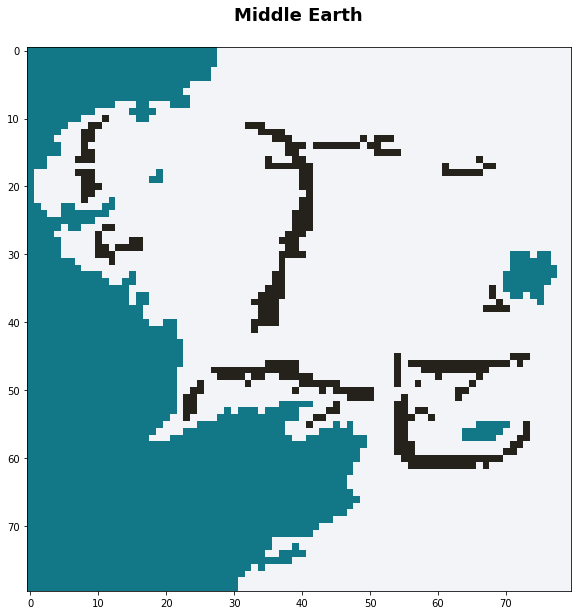

In [6]:
middle_earth_map = plt.imread("./Mapas/middle_earth_pixel_TOP.png")

fig1, ax1 = plt.subplots(figsize=(10,10))
#image = ax1.imshow(middle_earth_map, extent=[0, 80, 0, 80])
#plt.show()

#image
#cmap = plt.get_cmap("Paired")
cmap = plt.get_cmap("Paired")
#cmap = cmap.colors[0:10]
Ncolors = 10
mapColors = cmap(np.linspace(0, Ncolors/12, Ncolors))
my_cmap = ListedColormap(mapColors)
plt.register_cmap(name="my_cmap", cmap=my_cmap)
cmap = plt.get_cmap("my_cmap")
        
#print(len(cmap.colors[0:10]))

Npixelsperline = 80
H_middle_earth = np.ones((Npixelsperline,Npixelsperline))
for i in range(Npixelsperline):
    for j in range(Npixelsperline):
        if(middle_earth_map[i,j,0]<0.5): # If is not red.
            if(middle_earth_map[i,j,2]>0.5): # If is blue.
                H_middle_earth[i,j] = -1 # Is blue, then is water.
            else:
                H_middle_earth[i,j] = 0 # Is dark, then is mountain.
                #print("Dark!")
waterColor = [19/256, 121/256, 137/256, 1]
mountainColor = [38/256, 34/256, 28/256, 1]
emptyColor = [243/256, 245/256, 249/256, 1]#[226/256, 225/256, 224/256, 1]
simple_colormap = ListedColormap([waterColor, mountainColor, emptyColor])
levels = np.linspace(-1.5, 1.5, 4)
#print(Hmap)
norm = BoundaryNorm(levels, ncolors=3, clip=True)
image = ax1.imshow(H_middle_earth, alpha=1, cmap=simple_colormap, norm=norm)
ax1.set_title("Middle Earth\n", size=18, fontweight="bold")
plt.show()

In [7]:
anim_index=0
seeds = []

In [29]:
#
Nsitesperline = 80

#self.Nsitesperline = Nsitesperline
#self.Nsites = Nsitesperline**2

S = np.zeros((Nsitesperline,Nsitesperline)) # Spatial matrix.
#H = np.ones((Nsitesperline,Nsitesperline)) # Habitat matrix (habitability).
#self.I = np.zeros((Nsitesperline,Nsitesperline)) # Isolation matrix.
#self.Nspecies = Nspecies
#species_marker = 

#931938 #1231273512 #1209438(ruim) #89429356 #238034 #1238034

# Condição inicial
i0 = 24
j0 = 24
#S[21,3] = 1
#S[8,72] = 1
#S[52,52] = 1
S[i0,j0] = 1

# Parâmetros
nu = 0.008 # Especiação
mu = 0.02 # Mortalidade
pi = 0.8 # Colonização de sítio vizinho desocupado


[[6801264, 'spatialized_phylogeny_TOP1.gif'], [6801264, 'spatialized_phylogeny_TOP1.gif'], [6801264, 'spatialized_phylogeny_TOP2.gif'], [6801264, 'spatialized_phylogeny_TOP3.gif'], [6801264, 'spatialized_phylogeny_TOP3.gif'], [6801264, 'spatialized_phylogeny_TOP4.gif'], [6801264, 'spatialized_phylogeny_TOP5.gif'], [6801264, 'spatialized_phylogeny_TOP6.gif'], [6801264, 'spatialized_phylogeny_TOP7.gif'], [6801264, 'spatialized_phylogeny_TOP8.gif'], [6801264, 'spatialized_phylogeny_TOP8.gif'], [6801264, 'spatialized_phylogeny_TOP9.gif'], [6801264, 'spatialized_phylogeny_TOP9.gif'], [6801264, 'spatialized_phylogeny_TOP9.gif'], [6801264, 'spatialized_phylogeny_TOP9.gif'], [6801264, 'spatialized_phylogeny_animate.gif'], [6801264, 'spatialized_phylogeny_animate.gif'], [6801264, 'spatialized_phylogeny_animate.gif'], [6801264, 'spatialized_phylogeny_animate.gif'], [6801264, 'spatialized_phylogeny_animate.gif']]
0
Segmentation with 1 / 1 segments

Time: 0.0
Speciations:  [] ;  Extinctions:  [] .

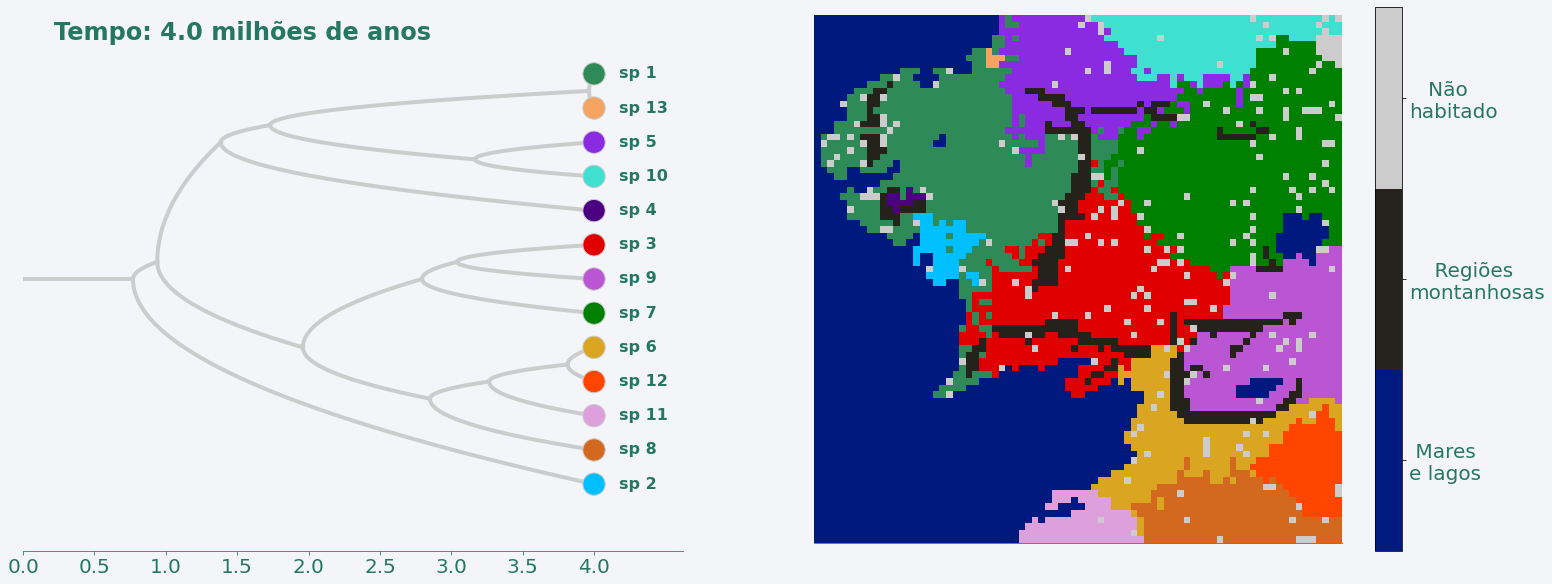

In [47]:
# Semente
seed = 6801264#int(random()*1000000000)
np.random.seed(seed)
seeds.append([seed])
animation_name = 'spatialized_phylogeny_animate.gif'
seeds[-1].append(animation_name)
anim_index += 1
print(seeds)

t = 0
F = np.array([[0]])
species=["sp 1"]

N, M = F.shape

markers=[i for i in range(N)]
extinctions=[]

phylogeny = Phylogeny(F, species=species, species_marker=markers, extinctions=extinctions, t=t)

meta = Metacommunity(S, H_middle_earth, phylogeny, ispecies=[i0], jspecies=[j0])
meta.dynamic_parameters(pi=pi, mu=mu, nu=nu)

fig, ax = plt.subplots(1, 2, figsize=(26,10))

# My colormap.
#cmap = plt.get_cmap("Paired")
#mapColors = cmap(np.linspace(0, Ncolors/12, Ncolors))
#listofcolors = ["#ff0000", "#ff8000", "#ffff00", "#00ff00", "#00ffff", "#0080ff", "#0000ff", "#8000ff", "#ff00ff", "#ff0080", "#800080", "#008080", "#808000", "#80ff80", "#8080ff", "#ff8080", "#808080"]
#['#8A2BE2','#40E0D0','#DAA520','#FF0000','#2E8B57','#4B0082','#D2691E','#DDA0DD','#FF4500','#00FF7F','#BA55D3','#DC143C','#008000','#FF69B4','#00BFFF','#F4A460']
listofcolors2 = ['#2E8B57','#00BFFF','#E00000','#4B0082','#8A2BE2','#DAA520','#008000','#D2691E','#BA55D3','#40E0D0','#DDA0DD','#FF4500','#F4A460','#00FF7F','#FF69B4','#DC143C']
#['#2E8B57','#40E0D0','#8A2BE2','#DAA520','#E00000','#DDA0DD','#D2691E','#FF4500','#00BFFF','#00FF7F','#BA55D3','#DC143C','#008000','#4B0082','#FF69B4','#F4A460']
Ncolors = len(listofcolors2)
my_cmap = ListedColormap(listofcolors2)#mapColors
plt.register_cmap(name="my_cmap", cmap=my_cmap)

colormap = "my_cmap"#"Set1"#"Paired"#"turbo"#"tab10_r"#

background_color = '#f3f5f9' #'black'
text_color = '#257764' #'gray'

#waterColor = [0, 0.2, 0.8, 1]#[0/256, 121/256, 137/256, 1] #[0, 0.1, 0.8, 1]
#mountainColor = [0, 0, 0, 1]#[38/256, 34/256, 28/256, 1]#[0.1, 0.1, 0.1, 1]
#emptyColor = [0.8, 0.8, 0.8, 1]#[226/256, 225/256, 224/256, 1]#
waterColor = [0, 0.1, 0.5, 1]#[19/256, 121/256, 137/256, 1]
mountainColor = [38/256, 34/256, 28/256, 1]
emptyColor = [0.8, 0.8, 0.8, 1]#[226/256, 225/256, 224/256, 1]#[243/256, 245/256, 249/256, 1]#


#ax.set_xlabel("kAnos (antes do presente)", color=text_color, fontweight="bold", fontsize=12, va="top")


fig.set_facecolor(background_color)
#fig.suptitle("Espécies na Terra Média", size=30, fontweight="bold", color=text_color)

for j in range(2):
    ax[j].set_facecolor(background_color)
    ax[j].spines['bottom'].set_color(text_color)
    ax[j].tick_params(axis='x', colors=text_color)
    ax[j].tick_params(axis='y', colors=text_color)
    ax[j].spines['top'].set_color('none') 
    ax[j].spines['right'].set_color('none')
    ax[j].spines['left'].set_color('none')


# Number of dynamic steps per frame.
Nstepsperframe = 4
Nframes = 200
phylogeny.dt=4/(Nframes*Nstepsperframe)
NspeciesMax = Ncolors

class EarlyBurst():
    def __init__(self, meta, fator=2):
        self.meta = meta
        self.Nspecies_ant = 1*meta.Nspecies
        self.f = fator
    def reduceBurst(self):
        if(self.meta.Nspecies>self.Nspecies_ant):
            self.meta.nu /= self.f
            self.Nspecies_ant += 1*self.meta.Nspecies

burst = EarlyBurst(meta, fator=3)
            
#phylogeny.update()

# Plot to initialize colorbar.
im = meta.PlotSpace(ax[1], cmap=colormap, water_color=waterColor, gap_color=mountainColor, empty_color=emptyColor, text_color=text_color)

# Colorbar.
tbar = np.linspace(-2, 0, 0+3)#NspeciesMax
lbar = [" Mares\ne lagos", "    Regiões\nmontanhosas", "   Não\nhabitado"]
for i in range(1, 0+1):#NspeciesMax
    lbar.append(("sp %d" % i))

cb = fig.colorbar(im, anchor=(0, 0.5), ticks=tbar)#
#cb.set_label(r"Espécies", fontsize=20, color=text_color)
cb.ax.set_yticklabels(lbar, color=text_color)
cb.ax.tick_params(labelsize=20)

def animate(i):
    # Plota a filogenia.
    if(phylogeny.t<1):
        xscale = 1.1
    else:
        xscale = 1.1*phylogeny.t
    if(phylogeny.N<8):
        yscale = 1.15*8
    else:
        yscale = 1.15*phylogeny.N
    
    # Clear the graphics.
    ax[0].clear()
    ax[1].clear()
        
    # Phylogeny plot.
    phyloplot(ax[0], meta.phylo, colormap=colormap, text_color=text_color, species_color=emptyColor, order=2, xscale=xscale, yscale=yscale, NspeciesMax=NspeciesMax, species_size=500)
    
    # Space metacommunity plot.
    meta.PlotSpace(ax[1], NspeciesMax=NspeciesMax, cmap=colormap, water_color=waterColor, gap_color=mountainColor, empty_color=emptyColor, text_color=text_color, ticks=False)
    
    # Make the dynamic.
    for i in range(Nstepsperframe):
        meta.matrix_dynamic(isolationEffect=True, environmentalEffect=True, enableInvasion=True)
        
        # Gambiarra para limitar número de espécies.
        if(meta.Nspecies>=NspeciesMax):
            meta.nu = 0
    
    # Gambiarra para especiar mais no começo e menos no final.
    burst.reduceBurst()
                
time_start = time()    
ani = FuncAnimation(fig=fig, func=animate, interval=150, frames=Nframes) #, interval=300
ani.save(animation_name,writer='ffmpeg')
print("Execution time: %.3f s" % (time() - time_start))
#plt.show()

9
Segmentation with 25 / 25 segments



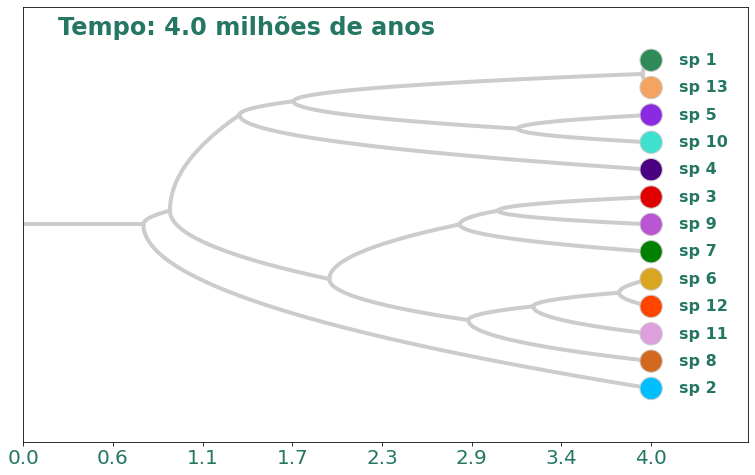

In [45]:
figb, bx = plt.subplots(1, figsize=(13,8))
xscale=1.1*meta.phylo.t
yscale=1.15*meta.Nspecies
phyloplot(bx, meta.phylo, colormap=colormap, text_color=text_color, species_color=emptyColor, order=2, xscale=xscale, yscale=yscale, NspeciesMax=NspeciesMax, species_size=500)

Segmentation with 1 / 1 segments

Time: 0.0
Speciations:  [] ;  Extinctions:  [] .
Time: 0.0
Speciations:  [] ;  Extinctions:  [] .
Time: 0.0
Speciations:  [] ;  Extinctions:  [] .
Time: 0.0
Speciations:  [] ;  Extinctions:  [] .
Segmentation with 1 / 1 segments

Time: 0.0
Speciations:  [] ;  Extinctions:  [] .
Time: 0.0
Speciations:  [] ;  Extinctions:  [] .
Time: 0.0
Speciations:  [] ;  Extinctions:  [] .
Time: 0.0
Speciations:  [] ;  Extinctions:  [] .
Segmentation with 1 / 1 segments

Time: 0.0
Speciations:  [] ;  Extinctions:  [] .
Time: 0.0
Speciations:  [] ;  Extinctions:  [] .
Time: 0.0
Speciations:  [] ;  Extinctions:  [] .
Time: 0.1
Speciations:  [] ;  Extinctions:  [] .
Segmentation with 1 / 1 segments

Time: 0.1
Speciations:  [] ;  Extinctions:  [] .
Time: 0.1
Speciations:  [] ;  Extinctions:  [] .
Time: 0.1
Speciations:  [] ;  Extinctions:  [] .
Time: 0.1
Speciations:  [] ;  Extinctions:  [] .
Segmentation with 1 / 1 segments

Time: 0.1
Speciations:  [] ;  Extinctions:  []

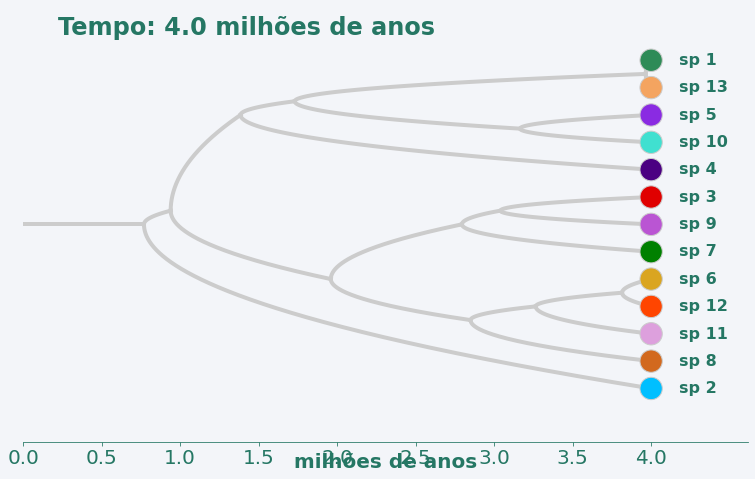

In [85]:
# Animate only phylogeny. Plot final phylogeny.

# Seed
seed = 6801264
np.random.seed(seed)
animation_name = 'phylogeny_animate.gif'

t = 0
F = np.array([[0]])
species=["sp 1"]

N, M = F.shape

markers=[i for i in range(N)]
extinctions=[]

phylogeny = Phylogeny(F, species=species, species_marker=markers, extinctions=extinctions, t=t)

meta = Metacommunity(S, H_middle_earth, phylogeny, ispecies=[i0], jspecies=[j0])
meta.dynamic_parameters(pi=pi, mu=mu, nu=nu)

#fig, ax = plt.subplots(1, 2, figsize=(26,10))
fig2, ax2 = plt.subplots(1, figsize=(13,8))

# My colormap.
listofcolors2 = ['#2E8B57','#00BFFF','#E00000','#4B0082','#8A2BE2','#DAA520','#008000','#D2691E','#BA55D3','#40E0D0','#DDA0DD','#FF4500','#F4A460','#00FF7F','#FF69B4','#DC143C']
Ncolors = len(listofcolors2)
my_cmap = ListedColormap(listofcolors2)
plt.register_cmap(name="my_cmap", cmap=my_cmap)

colormap = "my_cmap"

background_color = '#f3f5f9'
text_color = '#257764'

waterColor = [0, 0.1, 0.5, 1]
mountainColor = [38/256, 34/256, 28/256, 1]
emptyColor = [0.8, 0.8, 0.8, 1]

#fig.suptitle("Espécies na Terra Média", size=30, fontweight="bold", color=text_color)

fig2.set_facecolor(background_color)

ax2.set_facecolor(background_color)
ax2.spines['bottom'].set_color(text_color)
ax2.tick_params(axis='x', colors=text_color)
ax2.tick_params(axis='y', colors=text_color)
ax2.spines['top'].set_color('none') 
ax2.spines['right'].set_color('none')
ax2.spines['left'].set_color('none')

# Number of dynamic steps per frame.
Nstepsperframe = 4
Nframes = 200
phylogeny.dt=4/(Nframes*Nstepsperframe)
NspeciesMax = Ncolors

# Gambiarra para reduzir a probabilidade de especiação por sítio ao longo do tempo.
class EarlyBurst():
    def __init__(self, meta, fator=2):
        self.meta = meta
        self.Nspecies_ant = 1*meta.Nspecies
        self.f = fator
    def reduceBurst(self):
        if(self.meta.Nspecies>self.Nspecies_ant):
            self.meta.nu /= self.f
            self.Nspecies_ant += 1*self.meta.Nspecies

burst = EarlyBurst(meta, fator=3)
            
def animate2(i):
    # Plota a filogenia.
    if(phylogeny.t<1):
        xscale = 1.1
    else:
        xscale = 1.1*phylogeny.t
    if(phylogeny.N<8):
        yscale = 1.15*8
    else:
        yscale = 1.15*phylogeny.N
    
    # Clear the graphics.
    ax2.clear()
        
    # Phylogeny plot.
    phyloplot(ax2, meta.phylo, colormap=colormap, text_color=text_color, species_color=emptyColor, order=2, xscale=xscale, yscale=yscale, NspeciesMax=NspeciesMax, species_size=500)
    
    # Make the dynamic.
    for i in range(Nstepsperframe):
        meta.matrix_dynamic(isolationEffect=True, environmentalEffect=True, enableInvasion=True)
        
        # Gambiarra para limitar número de espécies.
        if(meta.Nspecies>=NspeciesMax):
            meta.nu = 0
    
    # Gambiarra para reduzir a probabilidade de especiação por sítio no final.
    burst.reduceBurst()
        
        
time_start = time()    
ani = FuncAnimation(fig=fig2, func=animate2, interval=150, frames=Nframes)
ani.save(animation_name,writer='ffmpeg')
print("Execution time: %.3f s" % (time() - time_start))

# Plot final phylogeny.
#phyloplot(ax3, meta.phylo, colormap=colormap, text_color=text_color, species_color=emptyColor, order=2, xscale=xscale, yscale=yscale, NspeciesMax=NspeciesMax, species_size=500)
ax2.set_xlabel("milhões de anos", color=text_color, fontweight="bold", fontsize=20, ha="center", va="bottom", labelpad=15)
fig2.savefig("phylogeny_final.png")
plt.show()

In [94]:
ax2.set_xlabel("milhões de anos", color=text_color, fontweight="bold", fontsize=20, ha='center', va="top", labelpad=15)#, 
fig2.savefig("phylogeny_final.png")
#fig2.show()

In [28]:
seeds

[[None]]

# Tests

In [ ]:
NspeciesMax=8
species_marker = [3, 1, 0, 2]
cmap = plt.get_cmap("rainbow")
Ncolors = cmap.N
mapColors = cmap(np.linspace(0, 1, NspeciesMax))
#print(mapColors)
new_index = 0
reMapColors = []
for e in species_marker:
    reMapColors.append(mapColors[e])
    new_index += 1
# New colormap.
print(reMapColors)
colormap = LinearSegmentedColormap.from_list("mycmap", reMapColors)
#print(colormap)

M = np.linspace(0, 3, 100)
M = np.reshape(M, (10,10))
#print(M)

levels = np.linspace(-0.5, NspeciesMax-1.5, NspeciesMax)
norm = BoundaryNorm(levels, ncolors=256, clip=True)
im = plt.imshow(M, alpha=1, cmap=colormap, norm=norm)

cb = fig.colorbar(im, anchor=(0, 0.5))

#plt.imshow(F, cmap)

In [ ]:
%matplotlib inline

background_color = '#f3f5f9' #'black'
text_color = '#257764' #'gray'

fig, ax = plt.subplots(1, figsize=(12,7))

#ax.set_yticks([])
#time_axis = np.linspace(0, phylo.t, 8)
#reverse_time = [("%.1f" % (phylo.t - timei)) for timei in time_axis]
#ax.set_xticks(time_axis)
#ax.set_xticklabels(reverse_time, fontsize=10, color=text_color)

#ax.text(0.8*phylo.t, 1.1*phylo.N, ("Tempo: %.1f kAnos" % phylo.t), color=text_color, fontweight="bold", fontsize=12, va="center")

ax.set_facecolor(background_color)
fig.set_facecolor(background_color)

ax.spines['bottom'].set_color(text_color)
ax.tick_params(axis='x', colors=text_color)
ax.tick_params(axis='y', colors=text_color)
ax.spines['top'].set_color('none') 
ax.spines['right'].set_color('none')
ax.spines['left'].set_color('none')

start_time = time()
phyloplot(ax, phylo, colormap='rainbow', species_color=text_color, order=2, xscale=1.1*phylo.t, yscale=1.1*phylo.N)

#plt.grid()

plt.show()
print(time()-start_time)

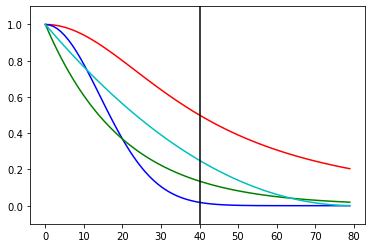

In [228]:
index = np.linspace(0, 79, 80)
d = np.abs(index-0)/80


def P(d, a):
    P = a/(a + d**2)
    return P

def G(d, s):
    G = np.exp(-(d/s)**2)
    return G

def E(d, b):
    E = np.exp(-(d/b))
    return E

def A(d, a):
    A = (1 - d)**2
    return A

n = 4
plt.plot(index, P(d, 1/n), c='r')
plt.plot(index, G(d, 1/n), c='b')
plt.plot(index, E(d, 1/n), c='g')
plt.plot(index, A(d, 1/n), c='c')
mean = 40*np.ones(10)
plt.plot(mean, np.linspace(-0.2, 1.2, 10), c='k')
plt.ylim(-0.1, 1.1)
#plt.xlim(-1, 40)
#plt.semilogy()
plt.show()